XGB : Extreme Gradient Boosting 

LGB : Light Gradient boosting 

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , train_test_split , cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_log_error,r2_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,f1_score,roc_auc_score,log_loss
import xgboost as xgb
import lightgbm as lgb

In [193]:
import pyodbc
import pandas as pd

server = 'dbserver'
database = 'Timeverse'
username = 'amits'
password = 'amit12345'

# Connection string
connection_string = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password};'
)

conn = None
cursor = None

try:
    # Establishing a connection to the SQL Server
    conn = pyodbc.connect(connection_string)

    # Instantiate a cursor
    cursor = conn.cursor()

    # Execute a SELECT query on the aps_trans table
    cursor.execute("""SELECT p.project_name, w.WorkItemID, w.Title, SUM(w.CompletedWork) as 'Sum of Completed Work', sum(w.OriginalEstimate) as 'Sum of Original Estimates' FROM 
Projects p
JOIN WorkItems w on (p.project_id = w.project_id)
group by p.project_name, w.WorkItemID, w.Title
""")

    # Fetch all rows from the result set
    rows = cursor.fetchall()
    df = pd.DataFrame([tuple(row) for row in rows], columns=[col[0] for col in cursor.description])
    print(df.head(20))

except pyodbc.Error as ex:
    print(f"Error: {ex}")

finally:
    # Close the cursor in a finally block if it is still open
    if cursor:
        cursor.close()


                                         project_name  WorkItemID  \
0   (D LandG) Test Project for Timeverse Timer Tes...       39405   
1   (D Treasury) Test Project for Timeverse Timer ...       39421   
2   (D Treasury) Test Project for Timeverse Timer ...       39422   
3                                  3AK Chemie Pvt Ltd       20839   
4                                  3AK Chemie Pvt Ltd       20840   
5                                  3AK Chemie Pvt Ltd       21071   
6                                  3AK Chemie Pvt Ltd       21089   
7                                  3AK Chemie Pvt Ltd       21868   
8                                  3AK Chemie Pvt Ltd       21870   
9                                  3AK Chemie Pvt Ltd       21873   
10                                 3AK Chemie Pvt Ltd       36428   
11                                 3AK Chemie Pvt Ltd       38640   
12                                 3AK Chemie Pvt Ltd       43078   
13                                

In [194]:
df.head(5)

,project_name,WorkItemID,Title,Sum of Completed Work,Sum of Original Estimates
0,(D LandG) Test Project for Timeverse Timer Tes...,39405,Test Bug,0.000000,1.0
1,(D Treasury) Test Project for Timeverse Timer ...,39421,Test Bug,0.000000,1.0
2,(D Treasury) Test Project for Timeverse Timer ...,39422,Test Task,0.049998,1.0
3,3AK Chemie Pvt Ltd,20839,Authorization of Bank API,0.000000,0.0
4,3AK Chemie Pvt Ltd,20840,Create Payment from API,0.000000,0.0


In [195]:
df['Remaining Work'] = df['Sum of Original Estimates'] - df['Sum of Completed Work']
print(df.tail())
def completion_status(row):
    diff = row['Sum of Original Estimates'] - row['Sum of Completed Work']
    if diff < 0:
        return 1  # Delayed
    else:
        return 0  # Not Delayed (includes early completion and on time)

# Apply the function to create a new column
df['CompletionStatus'] = df.apply(completion_status, axis=1)

print(df.head(5))

                                project_name  WorkItemID  \
53297  Yamazaki Mazak Machines Tools Pvt Ltd       78779   
53298  Yamazaki Mazak Machines Tools Pvt Ltd       78785   
53299  Yamazaki Mazak Machines Tools Pvt Ltd       81407   
53300  Yamazaki Mazak Machines Tools Pvt Ltd       82734   
53301  Yamazaki Mazak Machines Tools Pvt Ltd       82736   

                                                 Title  Sum of Completed Work  \
53297            Auto Bin Removal at time of Register                    7.51   
53298                     Error in Planning Worksheet                    4.30   
53299                 RGP / NRGP Deployment in Sandbox                   1.00   
53300  Validation of Zero to Remove in Qty Recd Field                    5.00   
53301                                 Auto RPO TO FPO                    4.00   

       Sum of Original Estimates  Remaining Work  
53297                       10.0            2.49  
53298                        4.0           -0.30  

In [196]:
df.head(5)

,project_name,WorkItemID,Title,Sum of Completed Work,Sum of Original Estimates,Remaining Work,CompletionStatus
0,(D LandG) Test Project for Timeverse Timer Tes...,39405,Test Bug,0.000000,1.0,1.000000,0
1,(D Treasury) Test Project for Timeverse Timer ...,39421,Test Bug,0.000000,1.0,1.000000,0
2,(D Treasury) Test Project for Timeverse Timer ...,39422,Test Task,0.049998,1.0,0.950002,0
3,3AK Chemie Pvt Ltd,20839,Authorization of Bank API,0.000000,0.0,0.000000,0
4,3AK Chemie Pvt Ltd,20840,Create Payment from API,0.000000,0.0,0.000000,0


In [190]:
print(df.columns)
print("DataFrame shape :",df.shape)
print("DataFrame Datatype information :",df.info())

Index(['project_name', 'WorkItemID', 'Title', 'Sum of Completed Work',
       'Sum of Original Estimates', 'Remaining Work', 'CompletionStatus'],
      dtype='object')
DataFrame shape : (53302, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53302 entries, 0 to 53301
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   project_name               53302 non-null  object 
 1   WorkItemID                 53302 non-null  int64  
 2   Title                      53302 non-null  object 
 3   Sum of Completed Work      53302 non-null  float64
 4   Sum of Original Estimates  53302 non-null  float64
 5   Remaining Work             53302 non-null  float64
 6   CompletionStatus           53302 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 2.8+ MB
DataFrame Datatype information : None


KeyboardInterrupt: 

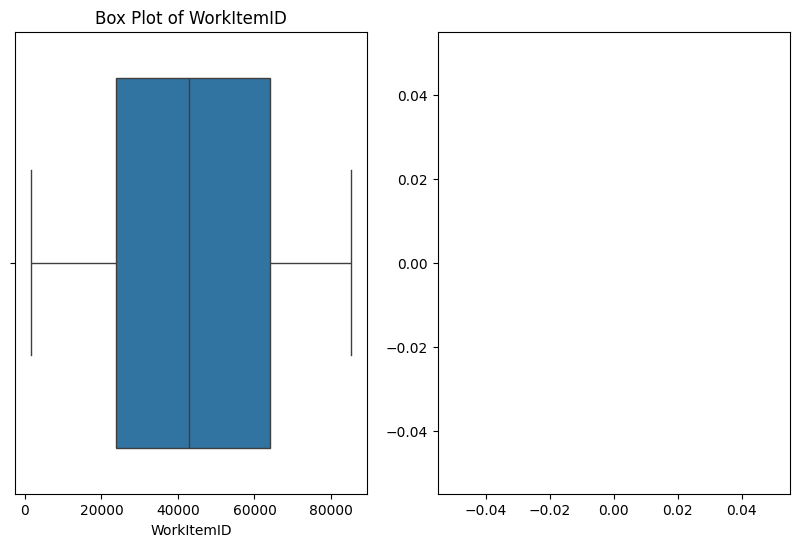

In [191]:
for column in df.select_dtypes(include=['number']).columns:
    # Create a new figure for each plot
    plt.figure(figsize=(10, 6))
    
    # Box plot
    plt.subplot(1, 2, 1)  # Subplot 1: Box plot
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    
    # Distribution plot
    plt.subplot(1, 2, 2)  # Subplot 2: Distribution plot
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution Plot of {column}')
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Show the plots
    plt.show()

In [ ]:
df.describe().T

On the bases of Data of Remaining Work we classify them 

In [ ]:
def completion_status(row):
    diff = row['Sum of Original Estimates'] - row['Sum of Completed Work']
    if diff < 0:
        return 1  # Delayed
    else:
        return 0  # Not Delayed (includes early completion and on time)

# Apply the function to create a new column
df['CompletionStatus'] = df.apply(completion_status, axis=1)

print(df.head(5))


In [ ]:
df.head(5)

In [ ]:
df.tail(5)

To Create Stage of Task and percentage of completion Task 

In [ ]:
df['Completion Percentage'] = (df['Sum of Completed Work'] / df['Sum of Original Estimates']) * 100
print(df.head())

In [ ]:
df.tail()

In [ ]:
df.isnull().sum()

In [ ]:
# Assuming df is your DataFrame containing 'Sum of Completed Work' and 'Sum of Original Estimates' columns

# Filter rows where both 'Sum of Completed Work' and 'Sum of Original Estimates' are zero
zero_completion_rows = df[(df['Sum of Original Estimates'] == 0)]

# Count the number of rows
count_zero_completion_rows = zero_completion_rows.shape[0]

# Display the count
print("Number of rows where Sum of Completed Work and Sum of Original Estimates are zero:", count_zero_completion_rows)


In [ ]:
zero_completion_rows = df[(df['Sum of Completed Work'] == 0)]

# Count the number of rows
count_zero_completion_rows = zero_completion_rows.shape[0]

# Display the count
print("Number of rows where Sum of Completed Work and Sum of Original Estimates are zero:", count_zero_completion_rows)


In [ ]:
class_distribution = df['CompletionStatus'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate percentage of each class
class_percentage = df['CompletionStatus'].value_counts(normalize=True) * 100
print("Class Percentage:\n", class_percentage)

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE 
X = df[['Sum of Completed Work', 'Sum of Original Estimates', 'Remaining Work']]  # Features
y = df['CompletionStatus']  # Target variable

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate resampled features and target variable into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['CompletionStatus'])], axis=1)
df_resampled .shape

In [ ]:
class_distribution = df_resampled['CompletionStatus'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate percentage of each class
class_percentage = df_resampled['CompletionStatus'].value_counts(normalize=True) * 100
print("Class Percentage:\n", class_percentage)

In [ ]:
df_resampled.describe().T

In [ ]:
# Define the columns with outliers
columns_with_outliers = ['Sum of Completed Work', 'Sum of Original Estimates', 'Remaining Work']

# Function to remove outliers using quartile method
def remove_outliers_quartile(df, columns):
    df_no_outliers = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    return df_no_outliers
df_no_outliers = remove_outliers_quartile(df, columns_with_outliers)


In [ ]:
df_no_outliers.shape

In [ ]:
df.tail(20)

In [ ]:
df.shape

In [ ]:
from imblearn.over_sampling import SMOTE 
X = df[['Sum of Completed Work', 'Sum of Original Estimates', 'Remaining Work']]  # Features
y = df['CompletionStatus']  # Target variable

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate resampled features and target variable into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['CompletionStatus'])], axis=1)
df_resampled .shape

In [ ]:
df_resampled.tail(20)

In [197]:
import numpy as np

def calculate_completion_percentage(row):
    if row['CompletionStatus'] == 1 and row['Sum of Completed Work'] != 0:
        # row['CompletionPercentage'] = (row['Sum of Original Estimates'] / row['Sum of Completed Work']) * 100
        return (row['Sum of Original Estimates'] / row['Sum of Completed Work']) * 100
    elif row['CompletionStatus'] == 0 and row['Sum of Original Estimates'] != 0:
        # row['CompletionPercentage'] = (row['Sum of Completed Work'] / row['Sum of Original Estimates']) * 100
        return (row['Sum of Completed Work'] / row['Sum of Original Estimates']) * 100
    elif row['Sum of Original Estimates'] == 0 and row['Sum of Completed Work']==0:
        # row['CompletionPercentage'] = 0  # Assign NaN for rows where calculation is not possible
        print("hii")
        return 0
    else:
        return "Hii"

df['CompletionPercentage']=df.apply(calculate_completion_percentage, axis=1)
df.head(20)

hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii
hii


,project_name,WorkItemID,Title,Sum of Completed Work,Sum of Original Estimates,Remaining Work,CompletionStatus,CompletionPercentage
0,(D LandG) Test Project for Timeverse Timer Tes...,39405,Test Bug,0.000000,1.0,1.000000,0,0.000000
1,(D Treasury) Test Project for Timeverse Timer ...,39421,Test Bug,0.000000,1.0,1.000000,0,0.000000
2,(D Treasury) Test Project for Timeverse Timer ...,39422,Test Task,0.049998,1.0,0.950002,0,4.999800
3,3AK Chemie Pvt Ltd,20839,Authorization of Bank API,0.000000,0.0,0.000000,0,0.000000
4,3AK Chemie Pvt Ltd,20840,Create Payment from API,0.000000,0.0,0.000000,0,0.000000
5,3AK Chemie Pvt Ltd,21071,Posted Purchase Receipt,0.000000,0.0,0.000000,0,0.000000
6,3AK Chemie Pvt Ltd,21089,"Send notification to sales, purchase and finan...",0.000000,0.0,0.000000,0,0.000000
7,3AK Chemie Pvt Ltd,21868,Training of Expense Entries in Business Central,0.000000,0.0,0.000000,0,0.000000
8,3AK Chemie Pvt Ltd,21870,Requirement Understanding for Zoho Expense,0.000000,0.0,0.000000,0,0.000000
9,3AK Chemie Pvt Ltd,21873,FDD Prapration,0.000000,0.0,0.000000,0,0.000000


In [198]:
df_resampled.isnull().sum()
df_filtered = df[(df['Sum of Completed Work'] != 0) | (df['Sum of Original Estimates'] != 0) | (df['Remaining Work'] != 0)]

In [199]:
df_filtered.head(20)

,project_name,WorkItemID,Title,Sum of Completed Work,Sum of Original Estimates,Remaining Work,CompletionStatus,CompletionPercentage
0,(D LandG) Test Project for Timeverse Timer Tes...,39405,Test Bug,0.000000,1.0,1.000000,0,0.000000
1,(D Treasury) Test Project for Timeverse Timer ...,39421,Test Bug,0.000000,1.0,1.000000,0,0.000000
2,(D Treasury) Test Project for Timeverse Timer ...,39422,Test Task,0.049998,1.0,0.950002,0,4.999800
10,3AK Chemie Pvt Ltd,36428,CHECK THE PO REPORT ERROR,0.000000,1.0,1.000000,0,0.000000
11,3AK Chemie Pvt Ltd,38640,Check & update the GST base amount not reflect...,5.949999,2.0,-3.949999,1,33.613451
12,3AK Chemie Pvt Ltd,43078,Meeting With Client.,0.000000,1.0,1.000000,0,0.000000
13,3AK Chemie Pvt Ltd,43357,Meeting With Client,0.000000,0.5,0.500000,0,0.000000
14,3AK Chemie Pvt Ltd,43833,Performa invoice new changes,9.003332,4.0,-5.003332,1,44.427996
15,3AK Chemie Pvt Ltd,44299,Meeting : Discussion on Data fetching queries ...,1.000000,1.0,0.000000,0,100.000000
16,3AK Chemie Pvt Ltd,44302,Meeting : Discussion on Data fetching queries ...,0.500000,1.0,0.500000,0,50.000000


In [200]:
df_filtered['CompletionPercentage'].unique().sum()

413773.7698312978

In [202]:
df.shape

(53302, 8)

In [ ]:
#PREPROESSING 
df['Remaining Work'] = df['Sum of Original Estimates'] - df['Sum of Completed Work']
print(df.tail())
def completion_status(row):
    diff = row['Sum of Original Estimates'] - row['Sum of Completed Work']
    if diff < 0:
        return 1  # Delayed
    else:
        return 0  # Not Delayed (includes early completion and on time)

# Apply the function to create a new column
df['CompletionStatus'] = df.apply(completion_status, axis=1)

print(df.head(5))
from imblearn.over_sampling import SMOTE 
X = df[['Sum of Completed Work', 'Sum of Original Estimates', 'Remaining Work']]  # Features
y = df['CompletionStatus']  # Target variable

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate resampled features and target variable into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['CompletionStatus'])], axis=1)
df_resampled .shape
import numpy as np

def calculate_completion_percentage(row):
    if row['CompletionStatus'] == 1 and row['Sum of Completed Work'] != 0:
        # row['CompletionPercentage'] = (row['Sum of Original Estimates'] / row['Sum of Completed Work']) * 100
        return (row['Sum of Original Estimates'] / row['Sum of Completed Work']) * 100
    elif row['CompletionStatus'] == 0 and row['Sum of Original Estimates'] != 0:
        # row['CompletionPercentage'] = (row['Sum of Completed Work'] / row['Sum of Original Estimates']) * 100
        return (row['Sum of Completed Work'] / row['Sum of Original Estimates']) * 100
    elif row['Sum of Original Estimates'] == 0 and row['Sum of Completed Work']==0:
        # row['CompletionPercentage'] = 0  # Assign NaN for rows where calculation is not possible
        print("hii")
        return 0
    else:
        return "Hii"

df_resampled['CompletionPercentage']=df_resampled.apply(calculate_completion_percentage, axis=1)
df_resampled.head(20)
df_resampled.isnull().sum()
df_filtered = df_resampled[(df_resampled['Sum of Completed Work'] != 0) | (df_resampled['Sum of Original Estimates'] != 0) | (df_resampled['Remaining Work'] != 0)]

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE 

def preprocess_data(df):
    # Calculate Remaining Work
    df['Remaining Work'] = df['Sum of Original Estimates'] - df['Sum of Completed Work']

    # Define completion status function
    def completion_status(row):
        diff = row['Sum of Original Estimates'] - row['Sum of Completed Work']
        if diff < 0:
            return 1  # Delayed
        else:
            return 0  # Not Delayed (includes early completion and on time)

    # Apply completion status function
    df['CompletionStatus'] = df.apply(completion_status, axis=1)

    # Define function to calculate completion percentage
    def calculate_completion_percentage(row):
        if row['CompletionStatus'] == 1 and row['Sum of Completed Work'] != 0:
            return (row['Sum of Original Estimates'] / row['Sum of Completed Work']) * 100
        elif row['CompletionStatus'] == 0 and row['Sum of Original Estimates'] != 0:
            return (row['Sum of Completed Work'] / row['Sum of Original Estimates']) * 100
        elif row['Sum of Original Estimates'] == 0 and row['Sum of Completed Work'] == 0:
            return 0
        else:
            return "Hii"

    # Apply completion percentage function
    df['CompletionPercentage'] = df.apply(calculate_completion_percentage, axis=1)

    # Filter out rows with all zeros
    df_filtered = df[(df['Sum of Completed Work'] != 0) |
                               (df['Sum of Original Estimates'] != 0) |
                               (df['Remaining Work'] != 0)]
    # print(df_filtered.head(5))
    Ndf=df_filtered.drop(['project_name','WorkItemID','Title','Remaining Work','CompletionPercentage','CompletionStatus'], axis=1)
    print(Ndf.head(5))
    return Ndf,df

# Example usage:
# df = pd.read_csv('your_data.csv')  # Load your dataset
preprocessed_df,df = preprocess_data(df)
# Now you have your preprocessed data ready to use in your pipeline.


    Sum of Completed Work  Sum of Original Estimates
6               49.086659                        5.0
7                7.950000                        5.0
8                7.966666                        3.0
9                0.450000                        0.5
10               4.330000                        4.0


In [ ]:
preprocessed_df.head(20)

,Sum of Completed Work,Sum of Original Estimates
6,49.086659,5.0
7,7.950000,5.0
8,7.966666,3.0
9,0.450000,0.5
10,4.330000,4.0
11,6.966666,12.0
12,3.033333,1.0
13,0.000000,1.5
14,0.750000,1.0
15,1.000000,1.0


In [206]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df_filtered.drop(['project_name','WorkItemID','Title','Remaining Work','CompletionPercentage','CompletionStatus'], axis=1)
y = df_filtered['CompletionPercentage']  # Target variable

# # Splitting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initializing the Linear Regression model
# model = LinearRegression()

# # Training the model
# model.fit(X_train, y_train)

# # Making predictions on the test set
# y_pred = model.predict(X_test)

# # Evaluating the model
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")
# # Calculate RMSE
# rmse = np.sqrt(mse)

In [ ]:
# print(rmse)

In [207]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initializing the Linear Regression model
# model = LinearRegression()

# # Training the model
# model.fit(X_train, y_train)

# # Making predictions on the test set
# y_pred = model.predict(X_test)

# # Evaluating the model
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")
# # Calculate RMSE
# rmse = np.sqrt(mse)

In [208]:
X_train.head(5)

,Sum of Completed Work,Sum of Original Estimates
45294,3.35000,6.0
11285,0.00000,3.0
39456,0.23000,2.0
12120,0.05000,1.0
23944,14.45333,14.0


In [ ]:
# Create a DataFrame to store actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the results DataFrame
print(results.head())

In [ ]:
from sklearn.metrics import r2_score

# Assuming y_test contains the true values and y_pred contains the predicted values
r2 = r2_score(y_test, y_pred)
print(f"R-squared value: {r2}")

In [ ]:
# Assuming df is your DataFrame containing the data
correlation_matrix = df_filtered.corr()
print(correlation_matrix)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
pip install statsmodels


In [ ]:
import statsmodels.api as sm

# Assuming 'X' is your feature matrix and 'y' is your target variable
X = df_filtered.drop(['CompletionStatus', 'CompletionPercentage'], axis=1)
y = df_filtered['CompletionPercentage']

# Add a constant to the feature matrix (required for the intercept)
X = sm.add_constant(X)

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary of the model
print(ols_model.summary())

In [ ]:
# Extract p-values from the summary of the model
p_values = ols_model.pvalues

# Print p-values for each column
print(p_values)


In [ ]:
# Define significance level
significance_level = 0.05

# Filter out statistically insignificant columns
significant_columns = p_values[p_values < significance_level].index

# Print the significant columns
print(significant_columns)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
vif_data = df_filtered.drop(['Sum of Completed Work','Remaining Work'],axis=1)
vif = pd.DataFrame()
vif["Feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [209]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 38.7504
- Mean Absolute Error: 35.0647
- R2 Score: 0.0068
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 39.5936
- Mean Absolute Error: 35.1558
- R2 Score: -0.0363


Lasso
Model performance for Training set
- Root Mean Squared Error: 38.7505
- Mean Absolute Error: 35.0679
- R2 Score: 0.0068
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 39.5598
- Mean Absolute Error: 35.1566
- R2 Score: -0.0346


Ridge
Model performance for Training set
- Root Mean Squared Error: 38.7504
- Mean Absolute Error: 35.0647
- R2 Score: 0.0068
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 39.5936
- Mean Absolute Error: 35.1558
- R2 Score: -0.0363


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.8022
- Mean Absolute Error: 0.1964
- R2 Score: 0.9996
--------

In [221]:
#final preprocessing 
import pandas as pd
from imblearn.over_sampling import SMOTE 

def preprocess_data(df):
    # Calculate Remaining Work
    df['Remaining Work'] = df['Sum of Original Estimates'] - df['Sum of Completed Work']

    # Define completion status function
    def completion_status(row):
        diff = row['Sum of Original Estimates'] - row['Sum of Completed Work']
        if diff < 0:
            return 1  # Delayed
        else:
            return 0  # Not Delayed (includes early completion and on time)

    # Apply completion status function
    df['CompletionStatus'] = df.apply(completion_status, axis=1)

    # Define function to calculate completion percentage
    def calculate_completion_percentage(row):
        if row['CompletionStatus'] == 1 and row['Sum of Completed Work'] != 0:
            return (row['Sum of Original Estimates'] / row['Sum of Completed Work']) * 100
        elif row['CompletionStatus'] == 0 and row['Sum of Original Estimates'] != 0:
            return (row['Sum of Completed Work'] / row['Sum of Original Estimates']) * 100
        elif row['Sum of Original Estimates'] == 0 and row['Sum of Completed Work'] == 0:
            return 0
        else:
            return "Hii"

    # Apply completion percentage function
    df['CompletionPercentage'] = df.apply(calculate_completion_percentage, axis=1)

    # Filter out rows with all zeros
    df_filtered = df[(df['Sum of Completed Work'] != 0) |
                               (df['Sum of Original Estimates'] != 0) |
                               (df['Remaining Work'] != 0)]
    # print(df_filtered.head(5))
    Ndf=df_filtered.drop(['project_name','WorkItemID','Title','Remaining Work','CompletionPercentage','CompletionStatus'], axis=1)
    print(Ndf.head(5))
    return Ndf

# Example usage:
# df = pd.read_csv('your_data.csv')  # Load your dataset
preprocessed_df = preprocess_data(df)

    Sum of Completed Work  Sum of Original Estimates
0                0.000000                        1.0
1                0.000000                        1.0
2                0.049998                        1.0
10               0.000000                        1.0
11               5.949999                        2.0


In [222]:
def predict(X):
    return model.predict(X)

In [210]:
model=RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [226]:
# Define pipeline
from sklearn.preprocessing import FunctionTransformer
def preprocess_data(df):
    # Calculate Remaining Work
    df['Remaining Work'] = df['Sum of Original Estimates'] - df['Sum of Completed Work']

    # Define completion status function
    def completion_status(row):
        diff = row['Sum of Original Estimates'] - row['Sum of Completed Work']
        if diff < 0:
            return 1  # Delayed
        else:
            return 0  # Not Delayed (includes early completion and on time)

    # Apply completion status function
    df['CompletionStatus'] = df.apply(completion_status, axis=1)

    # Define function to calculate completion percentage
    def calculate_completion_percentage(row):
        if row['CompletionStatus'] == 1 and row['Sum of Completed Work'] != 0:
            return (row['Sum of Original Estimates'] / row['Sum of Completed Work']) * 100
        elif row['CompletionStatus'] == 0 and row['Sum of Original Estimates'] != 0:
            return (row['Sum of Completed Work'] / row['Sum of Original Estimates']) * 100
        elif row['Sum of Original Estimates'] == 0 and row['Sum of Completed Work'] == 0:
            return 0
        else:
            return "Hii"

    # Apply completion percentage function
    df['CompletionPercentage'] = df.apply(calculate_completion_percentage, axis=1)

    # Filter out rows with all zeros
    df_filtered = df[(df['Sum of Completed Work'] != 0) |
                               (df['Sum of Original Estimates'] != 0) |
                               (df['Remaining Work'] != 0)]
    # print(df_filtered.head(5))
    Ndf=df_filtered.drop(['project_name','WorkItemID','Title','Remaining Work','CompletionPercentage','CompletionStatus'], axis=1)
    print(Ndf.head(5))
    return Ndf

pipeline = Pipeline([
    ('preprocessing',  FunctionTransformer(preprocess_data)),  # Preprocessing step
    ('model',  model)  # Model step, replace with your desired model
])

In [228]:
predictions = pipeline.preprocessing(df)

AttributeError: 'Pipeline' object has no attribute 'preprocessing'

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
model=RandomForestRegressor()
# model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=2, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

In [215]:
y_pred = pipeline.predict(df)
print(y_pred)

AttributeError: 'function' object has no attribute 'transform'

In [ ]:
# Create a DataFrame to store actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the results DataFrame
print(results.head())

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already created the 'results' DataFrame
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Sort the DataFrame by the actual values for better visualization
results_sorted = results.sort_values('Actual')

# Create a line plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(results_sorted['Actual'], label='Actual', marker='o')
plt.plot(results_sorted['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
